# A Plot of $k_{obs}$ vs. $\%H_2SO_4$ or $H_0$

This code will create the figure 2 in the discussion that plots $k_{obs}$ vs. $\% H_2SO_4$ and $\log{k_{obs}}$ vs $0.62H_0$ 

In [11]:
##############################################################
### Set up libraries and global variables
##############################################################

from interpolators import MakeInterpolationFunctionForH0inH2SO4byPercentWt  ### Local library

import pandas as pd
pd.options.mode.chained_assignment = None    # no warning message and no exception is raised

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import linregress

from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method. Returns smoothed x,y points
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method. Returns an interpolation function.
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method. Returns an interpolation function.
from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.

from matplotlib.patches import PathPatch
from matplotlib.path import Path


#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
github_H0_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_08/data/H0_data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.08
molwtH2O = 18.0
densityH2SO4 = 1.83
densityH2O = 1.000

### interpolation = interp1d(x1, y1, kind='linear')
### interpolation = CubicSpline(x1, y1)
### interpolation = scipy.interpolate.make_smoothing_spline(x1, y1, w=None, lam=0.03)



In [9]:
##############################################################
### DATAFRAME for ESTER HYDROLYSIS KINETIC DATA
##############################################################

##############################################################
### Import the data and perform calculations
##############################################################

Data_File_Name = "Yates_Table1.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 
#display(df)

df1 = (df.loc[df['Ester'] == 'MeOAc'])   ### Select only the MeOAc data

##############################################################
### Perform calculations
##############################################################

PercentH2SO4 = df1["%H2SO4"]
molesH2SO4 = PercentH2SO4 / molwtH2SO4
PercentH2O = 100 - PercentH2SO4
molesH2O = PercentH2O / molwtH2O
total_moles = molesH2SO4 + molesH2O
mole_fraction_H2SO4 = molesH2SO4 / total_moles

df1["X_H2SO4"] = mole_fraction_H2SO4

interpolator = MakeInterpolationFunctionForH0inH2SO4byPercentWt()
df1["H0"] = interpolator(PercentH2SO4)

m = 0.62
df1["HS"] = df1["H0"] * m

df1["log_k_obs"] = np.log10(df1["kobs"]) - 2

display(df1.head(3))

,Ester,%H2SO4,kobs,X_H2SO4,H0,HS,log_k_obs
0,MeOAc,14.1,1.50,0.029243,-0.597414,-0.370397,-1.823909
1,MeOAc,20.7,2.61,0.045716,-1.040195,-0.644921,-1.583359
2,MeOAc,28.3,4.22,0.067544,-1.509841,-0.936101,-1.374688


In [13]:
print(molwtH2O)

##############################################################
### DATAFRAME for ACTIVITY OF WATER IN H2SO4 MIXTURES
##############################################################

##############################################################
### Import the data
##############################################################

Data_File_Name = "01_Giauque_Table9_activityH2OinH2SO4.csv"

Filename = github_location + Data_File_Name

df2 = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 

#display(df1)

##############################################################
### Perform calculations
##############################################################

molal = df2["conc H2SO4 / m"]
mass_add_to_1_kg_water = molal * molwtH2SO4
total_mass_solution = mass_add_to_1_kg_water + 1000
percent_H2SO4 = mass_add_to_1_kg_water / total_mass_solution * 100

df2["%H2SO4"] = percent_H2SO4
df2["X_H2SO4"] = molal / (molal + 1000 / molwtH2O)

interpolator = MakeInterpolationFunctionForH0inH2SO4byPercentWt()
df2["H0"] = interpolator(df2["%H2SO4"])

m = 0.62
df2["HS"] = df2["H0"] * m


display(df2.head(3))

18.0


,conc H2SO4 / m,a_H2O,gamma_H2SO4,%H2SO4,X_H2SO4,H0,HS
0,1,0.9622,0.1300,8.931954,0.017682,-0.253089,-0.156915
1,2,0.9130,0.1253,16.399144,0.034749,-0.756237,-0.468867
2,3,0.8514,0.1411,22.734578,0.051233,-1.172347,-0.726855


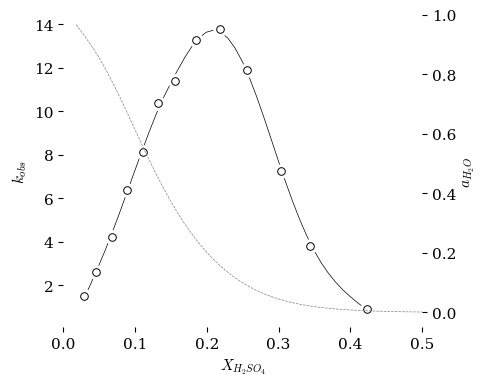

In [34]:
###################################################
### MAKE PLOT
###################################################


###################################################
### Select the data for ESTER HYDROLYSIS
###################################################

#x = df1["%H2SO4"]
x = df1["X_H2SO4"]
#x = -df1["HS"]

y = df1["kobs"]
#y = df1["log_k_obs"]

###################################################
### Interpolate the data
###################################################

### Using a smoothing function that returns smoothed y-values
x_s = x
y_s = y
if False:
       lowess_smoothed = lowess(y, x, 
                         frac=0.3, 
                         it=3, 
                         delta=0.0, 
                         xvals=None, 
                         is_sorted=False, 
                         missing='drop', 
                         return_sorted=True)
       x_s = lowess_smoothed[:,0]
       y_s = lowess_smoothed[:,1]

### Using a smoothing interpolation function that returns a Bspline function

interpolation = make_smoothing_spline(x_s, y_s,   ### The x and y data
                                      w=None,     ### A list of weights for each point (default = None)
                                      lam=0.000004)  ### A factor for the degree of smoothing. Change this to change the smoothness.
step = 0.01
x_smooth = np.arange(np.min(x), np.max(x)+step, step)
y_smooth = interpolation(x_smooth)


###################################################
### Select the data for WATER ACTIVITY
###################################################


#xa = df2["%H2SO4"]
xa = df2["X_H2SO4"]
#xa = -df2["H0"]

ya = df2["a_H2O"]
#ya = np.log10(df2["a_H2O"])

###################################################
### Interpolate Curve Spline
###################################################

### Using a smoothing function that returns smoothed y-values

x_s = xa
y_s = ya
if False:
       lowess_smoothed = lowess(ya, xa, 
                         frac=0.3, 
                         it=3, 
                         delta=0.0, 
                         xvals=None, 
                         is_sorted=False, 
                         missing='drop', 
                         return_sorted=True)
       x_s = lowess_smoothed[:,0]
       y_s = lowess_smoothed[:,1]

### Using a smoothing interpolation function that returns a Bspline function

interpolation = make_smoothing_spline(x_s, y_s,      ### The x and y data
                                      w=None,    ### A list of weights for each point (default = None)
                                      lam=0.000002)  ### A factor for the degree of smoothing. Change this to change the smoothness.
step = 0.01
xa_smooth = np.arange(np.min(xa), np.max(xa)+step, step)
ya_smooth = interpolation(xa_smooth)

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = "$X_{H_2SO_4}$"
#x_label = "$-0.62H_0$"

y1_label = "$k_{obs}$"
y2_label = "$a_{H_2O}$"

###################################################
### RATE vs ACIDITY Plot
###################################################

if True:                  # Set up axes for main plot
    ax.set(ylabel=y1_label, xlabel=x_label,
           xlim=[0,0.5],
#           ylim=[-2.1,-0.8]
           )

if True:                       # Data points for kobs vs Acidity
    ax.scatter(x, y, 
              marker = "o", s = 30, 
              color = "white", edgecolors = "black", linewidths=0.7, 
              zorder = 2)
    ax.scatter(x, y,           # White circle behind each data point 
              marker = "o", s = 90, 
              color = "white", 
              zorder = 1)

ax.plot(x_smooth, y_smooth,    # Plot smoothed curve
        "-", color = "black", linewidth=0.5, 
        zorder = 0)

#ax.plot(x-.3, x-2.35,          # Red line with slope = 1
#        "-", color = "red", linewidth=0.4, 
#        zorder = 1)

###################################################
### aH2O vs ACIDITY Plot
###################################################

if True:                       # Set up axes for alternate plot
    ax2.set(ylabel=y2_label, xlabel=x_label,                
#            xlim=[0,85],      ### Set axis limits to zoom in         
            ylim=[-0.05,1]
       )
#ax2.yaxis.set_major_locator(plt.NullLocator())
#ax2.yaxis.set_major_formatter(plt.NullFormatter())



if False:                      # Data points for a_H2O vs Acidity
    ax2.scatter(xa, ya,
               marker = "o", s = 30, 
               color = "white", edgecolors = "black", linewidths=0.7, 
               zorder = 2)

ax2.plot(xa_smooth, ya_smooth,   # smoothed line for a_H2O vs Acidity
         "--", color = "gray", linewidth=0.5, 
         zorder = 0)   


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("fig3.pdf")

plt.show()



